
##Emergent market data analysis using Long Short Term Memory model

Looking from an investor’s perspective, stock market returns in the long run are one of the critical factors for making investments. Hence, predicting stock prices in emerging markets is very important for an investor. In this project, we have focused on studying the prediction of opening stock prices for four emerging markets: Brazil, Thailand, Hong Kong, and Philippines.



In [4]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#BVSP data

In [7]:
#Importing the data
dfBP= pd.read_csv('/content/drive/MyDrive/emergent-market-data/BVSP.csv')
dfBP.shape


(1054, 7)

In [8]:
dfBP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1054 non-null   object 
 1   Open       1053 non-null   float64
 2   High       1053 non-null   float64
 3   Low        1053 non-null   float64
 4   Close      1053 non-null   float64
 5   Adj Close  1053 non-null   float64
 6   Volume     1053 non-null   float64
dtypes: float64(6), object(1)
memory usage: 57.8+ KB


In [9]:
dfBP.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300.0
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200.0
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100.0
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100.0
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800.0
5,2018-01-09,79379.0,79415.0,78699.0,78864.0,78864.0,3458600.0
6,2018-01-10,78864.0,78864.0,78164.0,78201.0,78201.0,2759900.0
7,2018-01-11,78201.0,79365.0,78201.0,79365.0,79365.0,3409400.0
8,2018-01-12,79365.0,79440.0,78861.0,79349.0,79349.0,3577800.0
9,2018-01-15,79349.0,79847.0,79349.0,79752.0,79752.0,1941000.0


In [10]:
dfBP.isnull().values.any()

True

In [11]:
#fillup the missing value with the average of previous and next value
dfBP=dfBP.interpolate(method ='linear')
dfBP.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300.0
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200.0
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100.0
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100.0
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800.0
5,2018-01-09,79379.0,79415.0,78699.0,78864.0,78864.0,3458600.0
6,2018-01-10,78864.0,78864.0,78164.0,78201.0,78201.0,2759900.0
7,2018-01-11,78201.0,79365.0,78201.0,79365.0,79365.0,3409400.0
8,2018-01-12,79365.0,79440.0,78861.0,79349.0,79349.0,3577800.0
9,2018-01-15,79349.0,79847.0,79349.0,79752.0,79752.0,1941000.0


In [12]:
dfBP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1054 non-null   object 
 1   Open       1054 non-null   float64
 2   High       1054 non-null   float64
 3   Low        1054 non-null   float64
 4   Close      1054 non-null   float64
 5   Adj Close  1054 non-null   float64
 6   Volume     1054 non-null   float64
dtypes: float64(6), object(1)
memory usage: 57.8+ KB


In [13]:
dfBP.isnull().values.any()

False

Text(0.5, 0.98, 'BVSP')

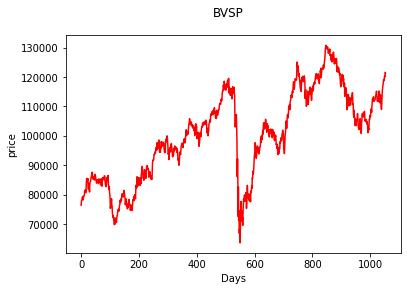

In [14]:
#Plot the time series graph
plt.plot(dfBP["Open"],'r')
plt.ylabel('price')
plt.xlabel('Days')
plt.suptitle('BVSP')

In [15]:
test = dfBP.tail(30)
train = dfBP.iloc[:-30]

In [16]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300.0
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200.0
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100.0
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100.0
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800.0


In [17]:
train.shape

(1024, 7)

In [18]:
test.shape

(30, 7)

In [19]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= train.iloc[:, 1:2].values
train_open

array([[ 76403.],
       [ 77889.],
       [ 77998.],
       ...,
       [114830.],
       [115181.],
       [113534.]])

In [20]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [ ]:
#train_open_scaled

In [21]:
train_open_scaled[60]

array([0.30176264])

Below we will be taking previous 70 days open datasteps to predict the next values so we are converting the data as per our input in LTSM layers.
i.e for taking 0 to 69 days open price to get 70th day price as output, 1 to 70 for 71, 2 to 71 for 72....

In [22]:
# Feature selection
def feature(train_open_scaled):
  
  xtrain=[]
  ytrain=[]
  for i in range(70,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-70:i,0])
    ytrain.append(train_open_scaled[i,0])

  xtrain, ytrain = np.array(xtrain), np.array(ytrain)

  return xtrain, ytrain

In [23]:
xtrain, ytrain = feature(train_open_scaled)

In [24]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [25]:
#xtrain

In [26]:
xtrain.shape

(954, 70, 1)

### Building the LSTM Network

In [27]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [28]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))

regression.add(Dense(128, activation='tanh'),)
regression.add(Dropout(0.2))
#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(Dense(128, activation='tanh'),)
regression.add(LSTM(units=50))
#regression.add(Dropout(0.2))

#Output layer , we wont pass any activation as its continous value model
#regression.add(Dense(units=1,activation='linear'))
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')




In [29]:
#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
32/32 [==============================] - 14s 175ms/step - loss: 0.0463
Epoch 2/100
32/32 [==============================] - 6s 177ms/step - loss: 0.0088
Epoch 3/100
32/32 [==============================] - 6s 175ms/step - loss: 0.0066
Epoch 4/100
32/32 [==============================] - 6s 178ms/step - loss: 0.0058
Epoch 5/100
32/32 [==============================] - 6s 178ms/step - loss: 0.0053
Epoch 6/100
32/32 [==============================] - 5s 170ms/step - loss: 0.0051
Epoch 7/100
32/32 [==============================] - 5s 171ms/step - loss: 0.0046
Epoch 8/100
32/32 [==============================] - 5s 170ms/step - loss: 0.0047
Epoch 9/100
32/32 [==============================] - 5s 171ms/step - loss: 0.0039
Epoch 10/100
32/32 [==============================] - 7s 215ms/step - loss: 0.0038
Epoch 11/100
32/32 [==============================] - 5s 171ms/step - loss: 0.0036
Epoch 12/100
32/32 [==============================] - 5s 169ms/step - loss: 0.0035
Epoch 13/100

### Predicting for test data

As we have 70 input in our layer, we will concatenate our train and test and will take last 70 values of our training set with test set

In [30]:
def concate(train,test,ss):
  test_open= test.iloc[:, 1:2].values #taking  open price
  total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 70 train point
  test_input = total[len(total)-len(test)-70:].values
  test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
  test_input= ss.transform(test_input)
  return test_input, test_open

In [31]:
test_input, test_open = concate(train,test,ss)

In [32]:
xtest= []
for i in range(70,100):
    xtest.append(test_input[i-70:i,0]) #creating input for lstm prediction

In [33]:
xtest= np.array(xtest)

In [34]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)


In [35]:
predicted_value= ss.inverse_transform(predicted_value)

### Plotting the data

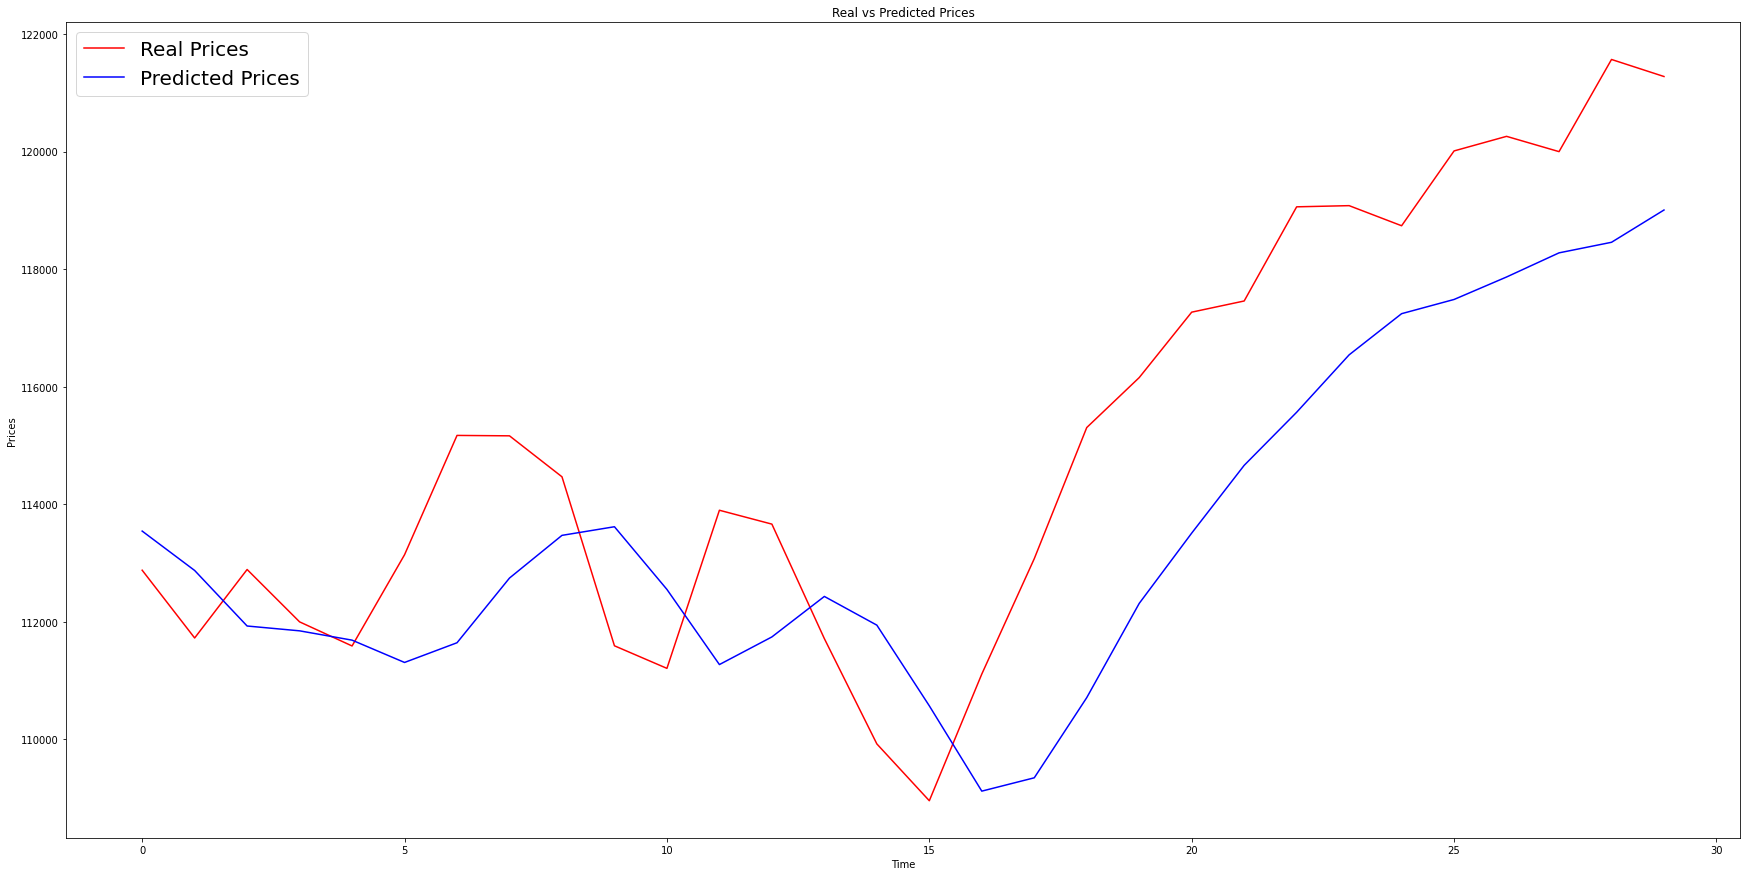

In [36]:
plt.figure(figsize=(30,15))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)


#PESi dataset

In [38]:
#Importing the data
dfPS= pd.read_csv('/content/drive/MyDrive/emergent-market-data/PSEi.csv')
dfPS.shape

(1279, 5)

In [39]:
dfPS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1279 non-null   object 
 1    Open   1279 non-null   float64
 2    High   1279 non-null   float64
 3    Low    1279 non-null   float64
 4    Close  1279 non-null   float64
dtypes: float64(4), object(1)
memory usage: 50.1+ KB


In [40]:
dfPS.head()

,Date,Open,High,Low,Close
0,04/05/22,1705.86,1708.89,1698.33,1701.18
1,04/04/22,1704.64,1706.77,1699.82,1702.93
2,04/01/22,1693.67,1701.99,1690.70,1701.31
3,03/31/22,1698.80,1701.95,1693.16,1695.24
4,03/30/22,1694.84,1702.67,1692.73,1698.40


In [41]:
dfPS.columns = ['Date','Open', 'High', 'Low', 'Close']
#df.index.name = "Date"

In [42]:
dfPS.isnull().values.any()

False

Text(0.5, 0.98, 'PSEi')

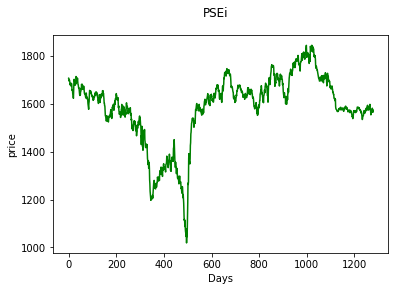

In [43]:
#Plot the time series graph
plt.plot(dfPS["Open"],'g')
plt.ylabel('price')
plt.xlabel('Days')
plt.suptitle('PSEi')

In [44]:
testPS = dfPS.tail(30)
trainPS = dfPS.iloc[:-30]

In [45]:
trainPS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1249 non-null   object 
 1   Open    1249 non-null   float64
 2   High    1249 non-null   float64
 3   Low     1249 non-null   float64
 4   Close   1249 non-null   float64
dtypes: float64(4), object(1)
memory usage: 48.9+ KB


In [46]:
trainPS.shape

(1249, 5)

In [47]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= trainPS.iloc[:, 1:2].values
train_open

array([[1705.86],
       [1704.64],
       [1693.67],
       ...,
       [1569.98],
       [1567.9 ],
       [1578.38]])

In [48]:
train_open_scaled= ss.fit_transform(train_open)
train_open_scaled

array([[0.83325043],
       [0.83177026],
       [0.81846087],
       ...,
       [0.66839353],
       [0.66586996],
       [0.67858486]])

In [49]:
xtrainPS, ytrainPS = feature(train_open_scaled)

In [50]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrainPS= np.reshape(xtrainPS,(xtrainPS.shape[0],xtrainPS.shape[1],1))

In [51]:
#fitting the network
regression.fit(xtrainPS,ytrainPS,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 10s 238ms/step - loss: 9.3168e-04
Epoch 2/100
40/40 [==============================] - 7s 173ms/step - loss: 8.4656e-04
Epoch 3/100
40/40 [==============================] - 7s 173ms/step - loss: 7.4016e-04
Epoch 4/100
40/40 [==============================] - 7s 175ms/step - loss: 7.2375e-04
Epoch 5/100
40/40 [==============================] - 7s 171ms/step - loss: 7.0355e-04
Epoch 6/100
40/40 [==============================] - 7s 170ms/step - loss: 8.3189e-04
Epoch 7/100
40/40 [==============================] - 7s 171ms/step - loss: 8.3453e-04
Epoch 8/100
40/40 [==============================] - 7s 173ms/step - loss: 7.0972e-04
Epoch 9/100
40/40 [==============================] - 7s 169ms/step - loss: 7.5636e-04
Epoch 10/100
40/40 [==============================] - 7s 171ms/step - loss: 6.7631e-04
Epoch 11/100
40/40 [==============================] - 7s 172ms/step - loss: 6.4746e-04
Epoch 12/100
40/40 [==============================]

Predicting for test data

In [52]:
test_input_PS, test_open_PS = concate(trainPS,testPS,ss)

In [53]:
xtest= []
for i in range(70,100):
    xtest.append(test_input_PS[i-70:i,0]) #creating input for lstm prediction

In [54]:
xtest= np.array(xtest)

In [55]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)


In [56]:
predicted_value= ss.inverse_transform(predicted_value)

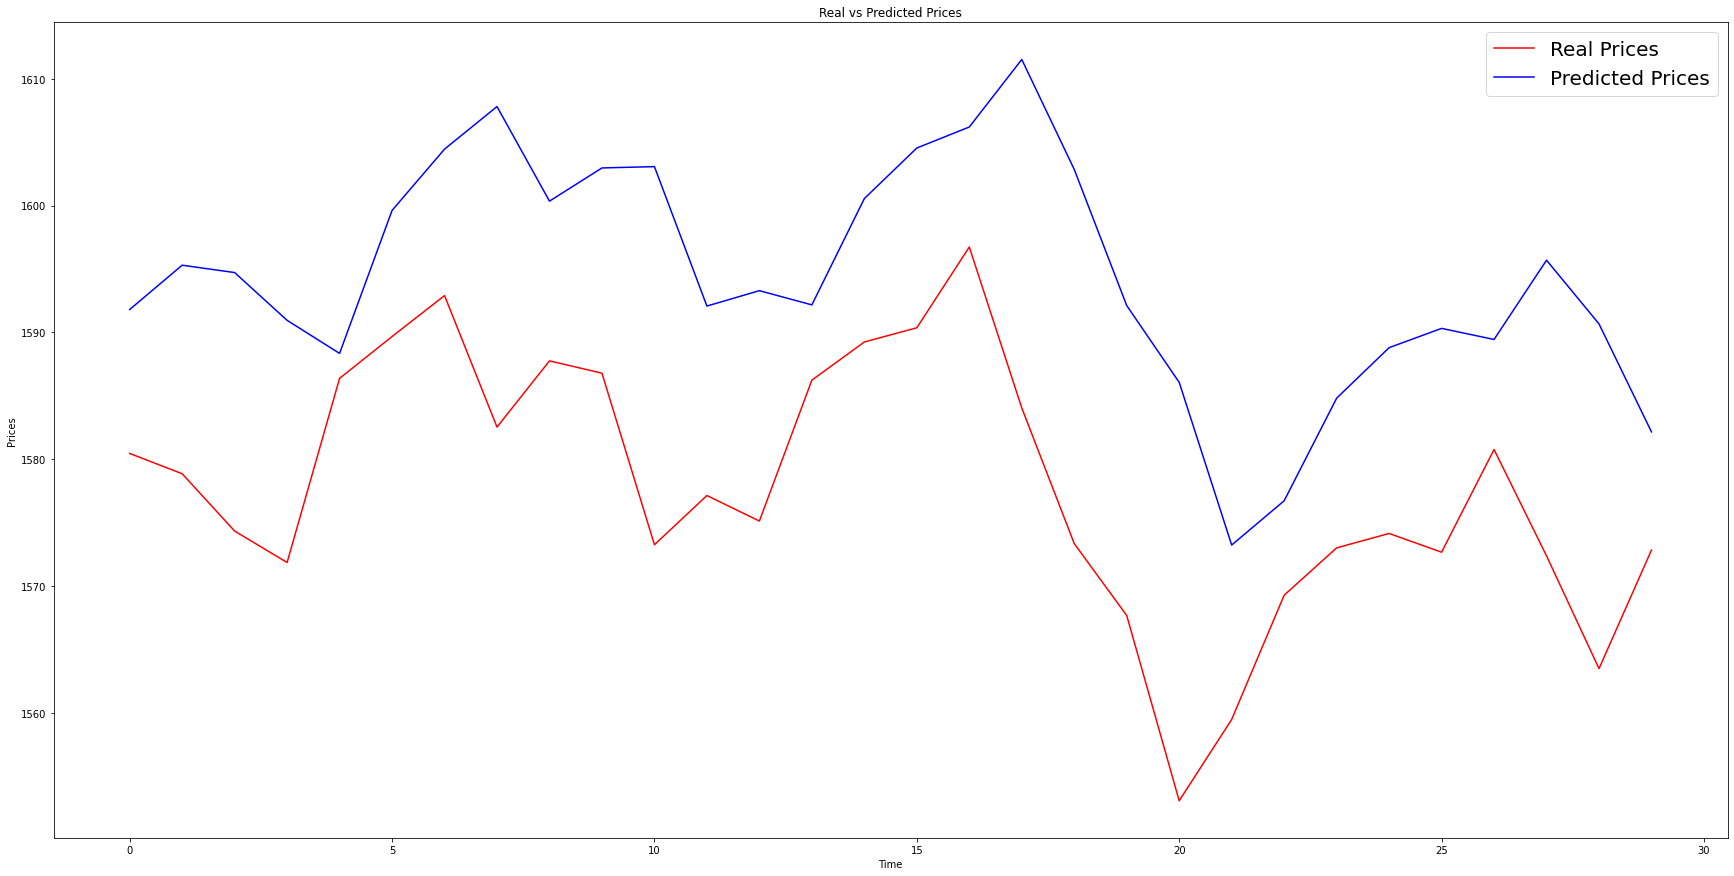

In [57]:
plt.figure(figsize=(30,15))
plt.plot(test_open_PS,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

#HSI Data


In [58]:
#Importing the data
dfHSI= pd.read_csv('/content/drive/MyDrive/emergent-market-data/HSI.csv')
dfHSI.shape

(1297, 7)

In [59]:
dfHSI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1297 non-null   object 
 1   Open       1296 non-null   float64
 2   High       1296 non-null   float64
 3   Low        1296 non-null   float64
 4   Close      1296 non-null   float64
 5   Adj Close  1296 non-null   float64
 6   Volume     1296 non-null   float64
dtypes: float64(6), object(1)
memory usage: 71.1+ KB


In [60]:
dfHSI.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,21993.359375,22189.310547,21883.820313,22150.400391,22150.400391,1.302378e+09
1,2017-01-04,22201.080078,22228.060547,22076.630859,22134.470703,22134.470703,1.437672e+09
2,2017-01-05,22302.640625,22483.009766,22230.310547,22456.689453,22456.689453,1.830652e+09
3,2017-01-06,22583.289063,22605.660156,22445.779297,22503.009766,22503.009766,1.389974e+09
4,2017-01-09,22561.109375,22626.429688,22476.349609,22558.689453,22558.689453,1.303533e+09


In [61]:
dfHSI.isnull().values.any()

True

In [62]:
dfHSI=dfHSI.interpolate(method ='linear')
dfHSI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1297 non-null   object 
 1   Open       1297 non-null   float64
 2   High       1297 non-null   float64
 3   Low        1297 non-null   float64
 4   Close      1297 non-null   float64
 5   Adj Close  1297 non-null   float64
 6   Volume     1297 non-null   float64
dtypes: float64(6), object(1)
memory usage: 71.1+ KB


Text(0.5, 0.98, 'HSI')

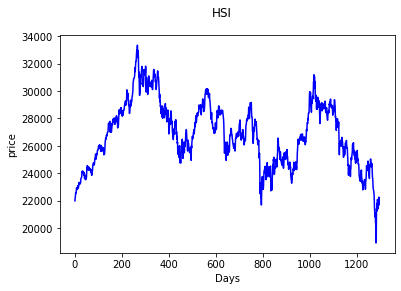

In [63]:
#Plot the time series graph
plt.plot(dfHSI["Open"],'b')
plt.ylabel('price')
plt.xlabel('Days')
plt.suptitle('HSI')

In [64]:
testHSI = dfHSI.tail(30)
trainHSI = dfHSI.iloc[:-30]

In [65]:
trainHSI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1267 non-null   object 
 1   Open       1267 non-null   float64
 2   High       1267 non-null   float64
 3   Low        1267 non-null   float64
 4   Close      1267 non-null   float64
 5   Adj Close  1267 non-null   float64
 6   Volume     1267 non-null   float64
dtypes: float64(6), object(1)
memory usage: 69.4+ KB


In [66]:
trainHSI.shape

(1267, 7)

In [67]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= trainHSI.iloc[:, 1:2].values
train_open

array([[21993.359375],
       [22201.080078],
       [22302.640625],
       ...,
       [24722.880859],
       [24633.660156],
       [24109.589844]])

In [68]:
train_open_scaled= ss.fit_transform(train_open)
train_open_scaled

array([[0.02553652],
       [0.04338294],
       [0.05210856],
       ...,
       [0.2600446 ],
       [0.25237916],
       [0.20735342]])

In [69]:
xtrainHSI, ytrainHSI = feature(train_open_scaled)

In [ ]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrainHSI= np.reshape(xtrainHSI,(xtrainHSI.shape[0],xtrainHSI.shape[1],1))

In [70]:
#fitting the network
regression.fit(xtrainHSI,ytrainHSI,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 11s 168ms/step - loss: 0.0017
Epoch 2/100
40/40 [==============================] - 7s 165ms/step - loss: 0.0013
Epoch 3/100
40/40 [==============================] - 7s 167ms/step - loss: 0.0013
Epoch 4/100
40/40 [==============================] - 7s 164ms/step - loss: 0.0014
Epoch 5/100
40/40 [==============================] - 7s 165ms/step - loss: 0.0014
Epoch 6/100
40/40 [==============================] - 7s 165ms/step - loss: 0.0012
Epoch 7/100
40/40 [==============================] - 7s 164ms/step - loss: 0.0011
Epoch 8/100
40/40 [==============================] - 7s 163ms/step - loss: 0.0011
Epoch 9/100
40/40 [==============================] - 7s 163ms/step - loss: 0.0011
Epoch 10/100
40/40 [==============================] - 7s 164ms/step - loss: 0.0012
Epoch 11/100
40/40 [==============================] - 7s 164ms/step - loss: 0.0012
Epoch 12/100
40/40 [==============================] - 7s 163ms/step - loss: 0.0011
Epoch 13/100

Predicting for test data

In [71]:
test_input_HSI, test_open_HSI = concate(trainHSI,testHSI,ss)

In [72]:
xtest= []
for i in range(70,100):
    xtest.append(test_input_HSI[i-70:i,0]) #creating input for lstm prediction

In [73]:
xtest= np.array(xtest)

In [74]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)


In [75]:
predicted_value= ss.inverse_transform(predicted_value)

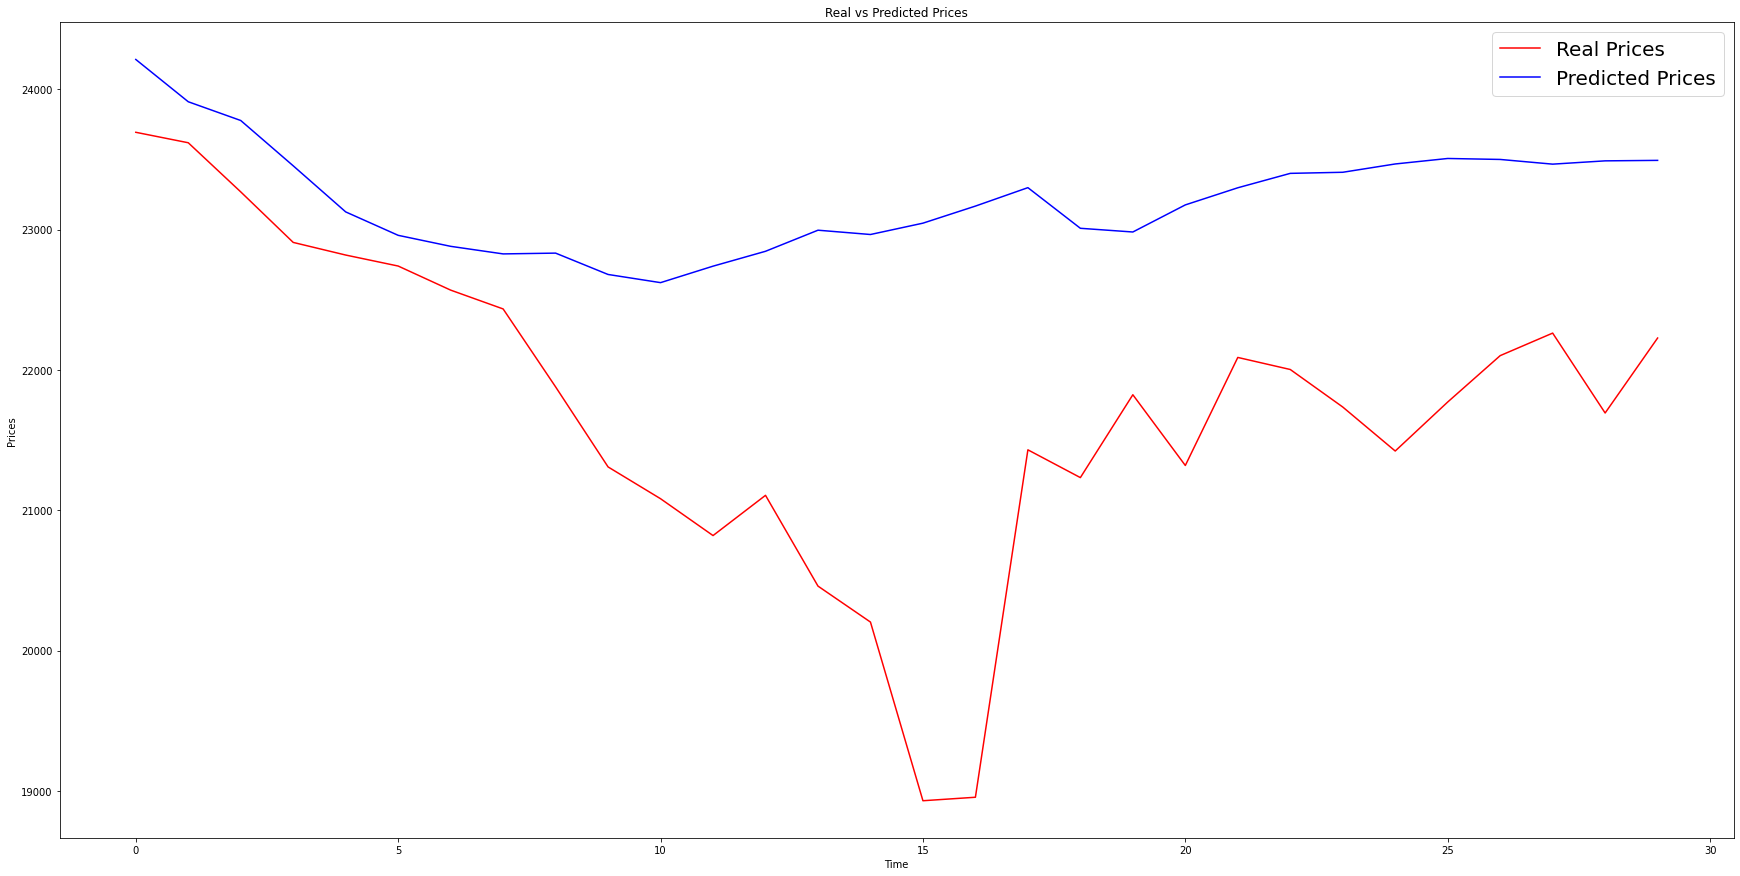

In [76]:
plt.figure(figsize=(30,15))
plt.plot(test_open_HSI,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

#SETi Data


In [103]:
#Importing the data
dfST= pd.read_csv('/content/drive/MyDrive/emergent-market-data/SETi.csv')
dfST.shape

(1276, 5)

In [104]:
dfST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1276 non-null   object 
 1    Open   1276 non-null   float64
 2    High   1276 non-null   float64
 3    Low    1276 non-null   float64
 4    Close  1276 non-null   float64
dtypes: float64(4), object(1)
memory usage: 50.0+ KB


In [105]:
dfST.head()

,Date,Open,High,Low,Close
0,04/06/22,7129.27,7130.92,7080.49,7109.26
1,04/05/22,7158.57,7158.57,7106.49,7156.07
2,04/04/22,7124.25,7163.21,7124.25,7163.21
3,04/01/22,7160.48,7162.44,7103.47,7152.88
4,03/31/22,7173.69,7203.47,7156.49,7203.47


In [106]:
dfST.columns = ['Date','Open', 'High', 'Low', 'Close']
#df.index.name = "Date"

In [107]:
dfST.isnull().values.any()

False

Text(0.5, 0.98, 'SETi')

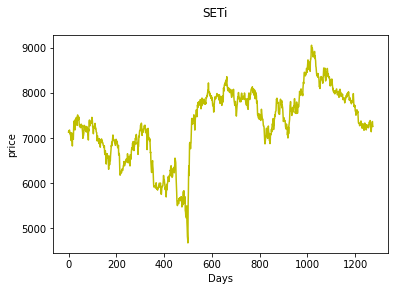

In [109]:
#Plot the time series graph
plt.plot(dfST["Open"],'-y')
plt.ylabel('price')
plt.xlabel('Days')
plt.suptitle('SETi')

In [110]:
testST = dfST.tail(30)
trainST = dfST.iloc[:-30]

In [111]:
trainST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1246 non-null   object 
 1   Open    1246 non-null   float64
 2   High    1246 non-null   float64
 3   Low     1246 non-null   float64
 4   Close   1246 non-null   float64
dtypes: float64(4), object(1)
memory usage: 48.8+ KB


In [112]:
trainST.shape

(1246, 5)

In [113]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= trainST.iloc[:, 1:2].values
train_open

array([[7129.27],
       [7158.57],
       [7124.25],
       ...,
       [7275.51],
       [7284.93],
       [7252.54]])

In [114]:
train_open_scaled= ss.fit_transform(train_open)
train_open_scaled

array([[0.56089416],
       [0.56758646],
       [0.55974757],
       ...,
       [0.59429625],
       [0.59644783],
       [0.58904976]])

In [115]:
xtrainST, ytrainST = feature(train_open_scaled)

In [116]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrainST= np.reshape(xtrainST,(xtrainST.shape[0],xtrainST.shape[1],1))

In [117]:
#fitting the network
regression.fit(xtrainST,ytrainST,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 7s 166ms/step - loss: 5.8254e-04
Epoch 2/100
40/40 [==============================] - 7s 164ms/step - loss: 4.0394e-04
Epoch 3/100
40/40 [==============================] - 7s 164ms/step - loss: 4.6409e-04
Epoch 4/100
40/40 [==============================] - 7s 166ms/step - loss: 4.4812e-04
Epoch 5/100
40/40 [==============================] - 7s 166ms/step - loss: 4.4028e-04
Epoch 6/100
40/40 [==============================] - 7s 166ms/step - loss: 5.5297e-04
Epoch 7/100
40/40 [==============================] - 7s 164ms/step - loss: 4.4864e-04
Epoch 8/100
40/40 [==============================] - 7s 167ms/step - loss: 4.1876e-04
Epoch 9/100
40/40 [==============================] - 7s 164ms/step - loss: 4.8197e-04
Epoch 10/100
40/40 [==============================] - 7s 164ms/step - loss: 5.3891e-04
Epoch 11/100
40/40 [==============================] - 7s 165ms/step - loss: 4.2011e-04
Epoch 12/100
40/40 [==============================] 

Predicting for test data

In [118]:
test_input_ST, test_open_ST = concate(trainST,testST,ss)

In [119]:
xtest= []
for i in range(70,100):
    xtest.append(test_input_ST[i-70:i,0]) #creating input for lstm prediction

In [120]:
xtest= np.array(xtest)

In [121]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)


In [122]:
predicted_value= ss.inverse_transform(predicted_value)

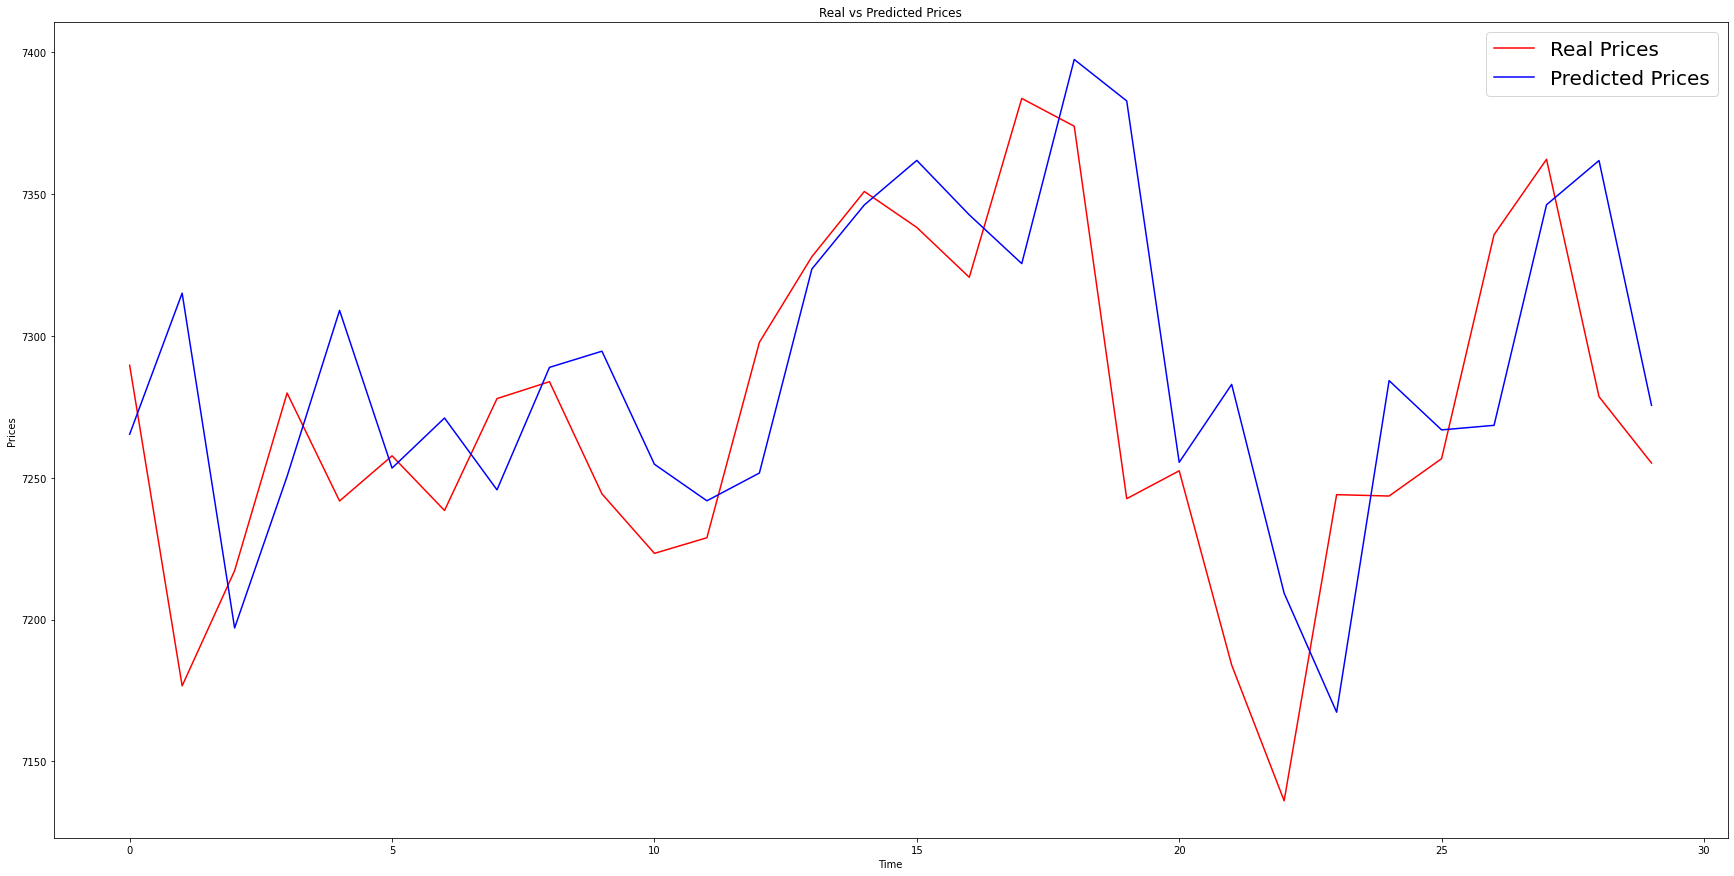

In [123]:
plt.figure(figsize=(30,15))
plt.plot(test_open_ST,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)